<a href="https://colab.research.google.com/github/jnsbrdbr/hopefully_last_thesis/blob/main/1191_TGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [ ]:
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [ ]:
# Import system packages
import os
import sys
import time
import logging
import importlib

#Import data manipulation libraries
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

from keras import initializers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle
import copy

import tensorflow as tf

import random
random.seed(123)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

In [ ]:
with open('/content/drive/MyDrive/10000/Tresult.pkl', "rb") as fh:
  result = pickle.load(fh)



In [ ]:
#divide data in to data_label and non_data label

y=result.label
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(y)):
  if y[i]==1:
    y[i]=0
  else:
    y[i]=1

result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel

In [ ]:
#splitting data in to test and train...

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y ,test_size=0.3,shuffle=True,random_state=1)#random_state=42,

In [ ]:
#number of fake in y
print('Number of fake in y:',collections.Counter(y)[1])

#number of real in y
print('Number of real in y:',collections.Counter(y)[0])

#number of fake in y_train
print('Number of fake in y_train:',collections.Counter(y_train)[1])

#number of real in y_train
print('Number of real in y_train:',collections.Counter(y_train)[0])

#number of fake in y_test
print('Number of fake in y_test:',collections.Counter(y_test)[1])

#number of real in y_test
print('Number of real in y_test:',collections.Counter(y_test)[0])

Number of fake in y: 3304
Number of real in y: 9910
Number of fake in y_train: 2316
Number of real in y_train: 6933
Number of fake in y_test: 988
Number of real in y_test: 2977


In [ ]:
#SMOTE

sm = SMOTE(sampling_strategy=1,k_neighbors=10)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

In [ ]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(X_train_oversampled)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

In [ ]:
# check how many anomalies are in our Testing set
print('Number of Normal Network packets in the Training set:', x_train.shape[0])
print('Number of Normal Network packets in the Testing set:', collections.Counter(y_test)[0])
print('Number of Anomalous Network packets in the Testing set:', collections.Counter(y_test)[1])

Number of Normal Network packets in the Training set: 6933
Number of Normal Network packets in the Testing set: 2977
Number of Anomalous Network packets in the Testing set: 988


In [ ]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=100, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(100, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [ ]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=100, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    #discriminator.add(Dense(128))
    #discriminator.add(Activation('relu'))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

In [ ]:
def get_gan_network(discriminator, generator, optimizer,input_dim=100):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [ ]:
len(x_test)

3965

In [ ]:
learning_rate = 0.00001
batch_size = 8
epochs = 20
adam = Adam(lr = learning_rate,beta_1 = 0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'],dataset['x_test'],dataset['y_test']

#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=100)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,100])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 100])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))
              

  5%|▌         | 870/17320 [00:59<09:38, 28.44it/s]

Epoch 0 Batch 865/866 [D loss: 0.529574] [G loss:0.220700]


 10%|█         | 1736/17320 [01:30<07:47, 33.30it/s]

Epoch 1 Batch 865/866 [D loss: 0.490913] [G loss:0.401666]


 15%|█▌        | 2603/17320 [01:57<07:24, 33.14it/s]

Epoch 2 Batch 865/866 [D loss: 0.147655] [G loss:0.087180]


 20%|██        | 3468/17320 [02:25<07:29, 30.85it/s]

Epoch 3 Batch 865/866 [D loss: 0.469428] [G loss:0.037281]


 25%|██▌       | 4337/17320 [02:57<06:59, 30.98it/s]

Epoch 4 Batch 865/866 [D loss: 0.123056] [G loss:0.049130]


 30%|███       | 5200/17320 [03:30<08:34, 23.56it/s]

Epoch 5 Batch 865/866 [D loss: 0.063564] [G loss:0.062447]


 35%|███▌      | 6069/17320 [04:06<06:14, 30.04it/s]

Epoch 6 Batch 865/866 [D loss: 0.158563] [G loss:0.040702]


 40%|████      | 6934/17320 [04:42<06:15, 27.65it/s]

Epoch 7 Batch 865/866 [D loss: 0.209957] [G loss:0.011359]


 45%|████▌     | 7799/17320 [05:16<06:48, 23.31it/s]

Epoch 8 Batch 865/866 [D loss: 0.298493] [G loss:0.013837]


 50%|█████     | 8664/17320 [05:50<05:58, 24.12it/s]

Epoch 9 Batch 865/866 [D loss: 0.168454] [G loss:0.041007]


 55%|█████▌    | 9530/17320 [06:17<04:29, 28.93it/s]

Epoch 10 Batch 865/866 [D loss: 0.307810] [G loss:0.012045]


 60%|██████    | 10396/17320 [06:44<03:34, 32.23it/s]

Epoch 11 Batch 865/866 [D loss: 0.019770] [G loss:0.013375]


 65%|██████▌   | 11262/17320 [07:12<03:19, 30.30it/s]

Epoch 12 Batch 865/866 [D loss: 0.115311] [G loss:0.052363]


 70%|███████   | 12130/17320 [07:42<02:34, 33.53it/s]

Epoch 13 Batch 865/866 [D loss: 0.225239] [G loss:0.012675]


 75%|███████▌  | 12996/17320 [08:10<02:20, 30.87it/s]

Epoch 14 Batch 865/866 [D loss: 0.041621] [G loss:0.006376]


 80%|████████  | 13864/17320 [08:34<01:35, 36.30it/s]

Epoch 15 Batch 865/866 [D loss: 0.060596] [G loss:0.003719]


 85%|████████▌ | 14727/17320 [08:59<01:25, 30.33it/s]

Epoch 16 Batch 865/866 [D loss: 0.009233] [G loss:0.016563]


 90%|█████████ | 15595/17320 [09:23<00:47, 36.16it/s]

Epoch 17 Batch 865/866 [D loss: 0.041530] [G loss:0.008424]


 95%|█████████▌| 16460/17320 [09:47<00:22, 38.61it/s]

Epoch 18 Batch 865/866 [D loss: 0.022654] [G loss:0.027332]


100%|██████████| 17320/17320 [10:12<00:00, 37.10it/s]

Epoch 19 Batch 865/866 [D loss: 0.090814] [G loss:0.098586]


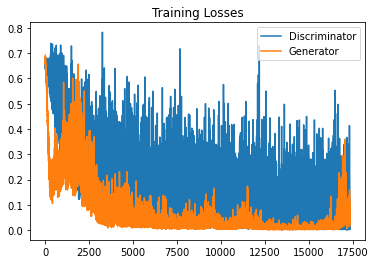

In [ ]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
np.ceil(x_test.shape[0] // batch_size)

495.0

In [ ]:
len(x_test)

3965

In [ ]:
# Predictions on the test set

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
   ran_from = t * batch_size
   if ran_from<len(x_test):
              print(ran_from)
              ran_to = (t + 1) * batch_size
              print(ran_to)
              image_batch = x_test[ran_from:ran_to] 
              print(image_batch)          
              tmp_rslt = discriminator.predict(x=image_batch,batch_size=4,verbose=0)        
              print(tmp_rslt)
              results = np.append(results, tmp_rslt)
              print(results)


Streaming output truncated to the last 5000 lines.
   2.77555756e-17  5.27355937e-14  2.30815367e-13  1.00000000e+00
   6.43485265e-13  1.32116540e-13  1.55607749e-11  3.42901263e-11
   2.62755805e-07  5.15568047e-07  2.65044451e-01  6.95940033e-02
   2.41938800e-01  2.05373362e-01  3.19428563e-01  2.60961294e-01
   1.60217602e-02  2.15136737e-01  3.05924207e-01  4.68172915e-02
   2.38246799e-01  3.86247188e-02  3.10342222e-01  1.59395158e-01
   2.44852379e-01  6.42010197e-02  9.37811956e-02  4.89458025e-01
   3.65255401e-02  7.75035545e-02  2.55623102e-01  5.13823211e-01
   1.89148396e-01  4.26987112e-01  3.19710821e-01  3.91645491e-01
   1.79079086e-01  1.16086513e-01  3.86831105e-01  6.29159510e-02]
 [ 2.62514621e-01  4.01860289e-02  2.61008739e-01  1.46417156e-01
   2.42623672e-01  2.66333167e-02  6.74140826e-02  2.13753637e-02
   5.85425019e-01  1.11816995e-01  8.01542119e-05  4.90042984e-01
   1.00210406e-01  5.67080498e-01  6.46314740e-01  2.35271096e-01
   3.55559468e-01  2.200

100%|██████████| 17320/17320 [10:30<00:00, 37.10it/s]

Streaming output truncated to the last 5000 lines.
   2.44891748e-01  6.42752200e-02  9.36857760e-02  4.86053497e-01
   4.21990380e-02  8.04991946e-02  2.62163401e-01  5.07978022e-01
   2.07315832e-01  4.28628057e-01  3.28937322e-01  3.97507042e-01
   1.99037313e-01  1.28620356e-01  3.90826136e-01  8.69632587e-02]]
[[0.7065928 ]
 [0.9984049 ]
 [0.9984112 ]
 [0.        ]
 [0.        ]
 [0.99813116]
 [0.99842983]
 [0.        ]]
[0.99848759 0.99840069 0.99567896 ... 0.99813116 0.99842983 0.        ]
3776
3784
[[ 2.64194906e-01  4.46015708e-02  2.75085270e-01  1.61882728e-01
   2.46606767e-01  4.94148433e-02  1.35152027e-01  4.34732676e-01
   2.11199522e-02  5.81286587e-02  9.00662708e-05  4.90042925e-01
   1.00212418e-01  5.67198157e-01  6.46342218e-01  2.35533804e-01
   3.59859467e-01  2.20161542e-01  1.87325016e-01  7.19147623e-02
   2.16336802e-01  3.95665690e-02  3.03689271e-01  1.47739381e-01
   2.33788177e-01  6.42307475e-02  6.60837889e-02  3.56427610e-01
   5.55265993e-02  3.16122

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
results

array([9.98487592e-01, 9.98400688e-01, 9.95678961e-01, 0.00000000e+00,
       9.98131156e-01, 9.97048616e-01, 9.98402119e-01, 9.98349071e-01,
       9.98429775e-01, 9.98430490e-01, 0.00000000e+00, 9.98432755e-01,
       9.98131275e-01, 9.98445511e-01, 9.98131275e-01, 0.00000000e+00,
       9.98378336e-01, 0.00000000e+00, 0.00000000e+00, 9.98429418e-01,
       9.98131275e-01, 9.97048616e-01, 9.95678902e-01, 9.26915288e-01,
       0.00000000e+00, 9.70518351e-01, 9.98131275e-01, 9.98429418e-01,
       9.98409152e-01, 9.98429775e-01, 1.28507614e-03, 9.98402119e-01,
       9.98404980e-01, 0.00000000e+00, 9.98430252e-01, 9.98443723e-01,
       9.98396754e-01, 9.98495936e-01, 0.00000000e+00, 9.98424172e-01,
       9.97239709e-01, 0.00000000e+00, 0.00000000e+00, 9.98244941e-01,
       9.95600700e-01, 9.98010576e-01, 0.00000000e+00, 9.98131156e-01,
       9.98131156e-01, 9.98443782e-01, 9.98428702e-01, 9.98378396e-01,
       9.98428583e-01, 9.98431802e-01, 9.98378336e-01, 0.00000000e+00,
      

In [ ]:
y_test=np.array(y_test)

In [ ]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print ('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9866771460240185
Mean score for anomalous packets : 0.0009442209777718219


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(results_df)


                  results               y_test
0               0.9984876            0.0000000
1               0.9984007            0.0000000
2               0.9956790            0.0000000
3               0.0000000            1.0000000
4               0.9981312            0.0000000
5               0.9970486            0.0000000
6               0.9984021            0.0000000
7               0.9983491            0.0000000
8               0.9984298            0.0000000
9               0.9984305            0.0000000
10              0.0000000            1.0000000
11              0.9984328            0.0000000
12              0.9981313            0.0000000
13              0.9984455            0.0000000
14              0.9981313            0.0000000
15              0.0000000            1.0000000
16              0.9983783            0.0000000
17              0.0000000            1.0000000
18              0.0000000            1.0000000
19              0.9984294            0.0000000
20           

In [ ]:
results

array([9.98487592e-01, 9.98400688e-01, 9.95678961e-01, 0.00000000e+00,
       9.98131156e-01, 9.97048616e-01, 9.98402119e-01, 9.98349071e-01,
       9.98429775e-01, 9.98430490e-01, 0.00000000e+00, 9.98432755e-01,
       9.98131275e-01, 9.98445511e-01, 9.98131275e-01, 0.00000000e+00,
       9.98378336e-01, 0.00000000e+00, 0.00000000e+00, 9.98429418e-01,
       9.98131275e-01, 9.97048616e-01, 9.95678902e-01, 9.26915288e-01,
       0.00000000e+00, 9.70518351e-01, 9.98131275e-01, 9.98429418e-01,
       9.98409152e-01, 9.98429775e-01, 1.28507614e-03, 9.98402119e-01,
       9.98404980e-01, 0.00000000e+00, 9.98430252e-01, 9.98443723e-01,
       9.98396754e-01, 9.98495936e-01, 0.00000000e+00, 9.98424172e-01,
       9.97239709e-01, 0.00000000e+00, 0.00000000e+00, 9.98244941e-01,
       9.95600700e-01, 9.98010576e-01, 0.00000000e+00, 9.98131156e-01,
       9.98131156e-01, 9.98443782e-01, 9.98428702e-01, 9.98378396e-01,
       9.98428583e-01, 9.98431802e-01, 9.98378336e-01, 0.00000000e+00,
      

In [ ]:
round_results=np.round(results,2)
print(round_results)

[1.   1.   1.   0.   1.   1.   1.   1.   1.   1.   0.   1.   1.   1.
 1.   0.   1.   0.   0.   1.   1.   1.   1.   0.93 0.   0.97 1.   1.
 1.   1.   0.   1.   1.   0.   1.   1.   1.   1.   0.   1.   1.   0.
 0.   1.   1.   1.   0.   1.   1.   1.   1.   1.   1.   1.   1.   0.
 0.   0.97 1.   0.   0.   0.   1.   0.91 1.   1.   1.   1.   0.   0.24
 1.   1.   1.   1.   1.   0.   1.   0.   1.   1.   0.77 1.   0.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   0.   0.   0.   1.   1.   1.
 1.   1.   1.   0.   1.   1.   1.   1.   0.   1.   1.   1.   1.   0.
 0.25 0.99 1.   1.   0.97 1.   0.   1.   1.   1.   0.   1.   0.   1.
 1.   1.   1.   0.   1.   0.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   0.   1.   1.   1.   0.   1.   0.   1.   1.   1.   1.   0.
 1.   1.   1.   0.   0.   1.   1.   1.   0.   1.   1.   0.   1.   1.
 1.   0.   1.   0.   0.   1.   1.   1.   1.   1.   1.   0.   0.   1.
 0.   1.   1.   1.   0.5  1.   1.   1.   1.   1.   0.   1.   1.   1.
 1.   0.   0.   1.   1.   1.   0

In [ ]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
print('per',per)
y_pred = round_results.copy()
y_pred = np.array(y_pred)
print('y_pred1',y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1
print(y_pred)

per 0.0
y_pred1 [1.   1.   1.   0.   1.   1.   1.   1.   1.   1.   0.   1.   1.   1.
 1.   0.   1.   0.   0.   1.   1.   1.   1.   0.93 0.   0.97 1.   1.
 1.   1.   0.   1.   1.   0.   1.   1.   1.   1.   0.   1.   1.   0.
 0.   1.   1.   1.   0.   1.   1.   1.   1.   1.   1.   1.   1.   0.
 0.   0.97 1.   0.   0.   0.   1.   0.91 1.   1.   1.   1.   0.   0.24
 1.   1.   1.   1.   1.   0.   1.   0.   1.   1.   0.77 1.   0.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   0.   0.   0.   1.   1.   1.
 1.   1.   1.   0.   1.   1.   1.   1.   0.   1.   1.   1.   1.   0.
 0.25 0.99 1.   1.   0.97 1.   0.   1.   1.   1.   0.   1.   0.   1.
 1.   1.   1.   0.   1.   0.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   0.   1.   1.   1.   0.   1.   0.   1.   1.   1.   1.   0.
 1.   1.   1.   0.   0.   1.   1.   1.   0.   1.   1.   0.   1.   1.
 1.   0.   1.   0.   0.   1.   1.   1.   1.   1.   1.   0.   0.   1.
 0.   1.   1.   1.   0.5  1.   1.   1.   1.   1.   0.   1.   1.   1.
 1.   0.   0.   

In [ ]:

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9984867591424968
Precision : 1.0
Recall : 0.9939271255060729
F1 : 0.9969543147208122


Confusion Matrix :


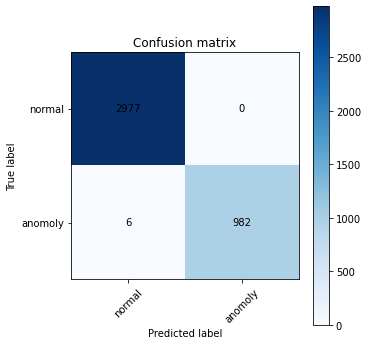

In [ ]:
cm = confusion_matrix(y_test, y_pred)
target_names = ['normal', 'anomoly']

print ('Confusion Matrix :')

def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm,target_names)

##Run the function##

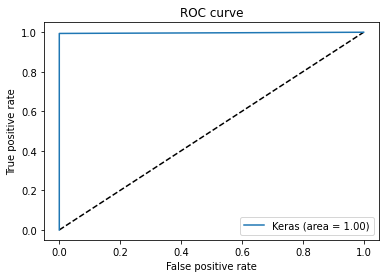

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()